In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mplcursors      # Allows interactive matplotlib graphs

# Used to smooth jagged histograms
from scipy.interpolate import BSpline
from scipy.ndimage.filters import gaussian_filter

# Local library to read and prep data from dmv akts events in splunk
import dmv_test_input as dti 

def read_log(case=1, field="duration"):
    # Read and prepare the dmv_akts. Case=1 ... sample ... =2 ... akts database

    df = dti.read_dmv_log(case=case)
    df["elapsed"] = abs(df['TestEndDateTime'] - df['TestStartDateTime']).dt.total_seconds()/60.
    df["passed"]  = (df.Result=="P")
    
    # Drop negative duration since they must be in error
    # Drop long durations because the chance of error is high
    
    df = df[ (df.duration>0) & (df.duration<120) & (df.elapsed<120)].reset_index()
    
    return df

df = read_log(case=2)
CHANGEPT = 14.5
print(f'{CHANGEPT=}')
col = ["ExamineeId", "TestStartDateTime", "TotalScore", "duration", "elapsed", "passed"]


Original length of sample data is 152519
2415 tests with Result, IPAddress, TotalScore = NaN dropped
Extra ip address dropped in 1056 tests
CHANGEPT=14.5


<IPython.core.display.Javascript object>


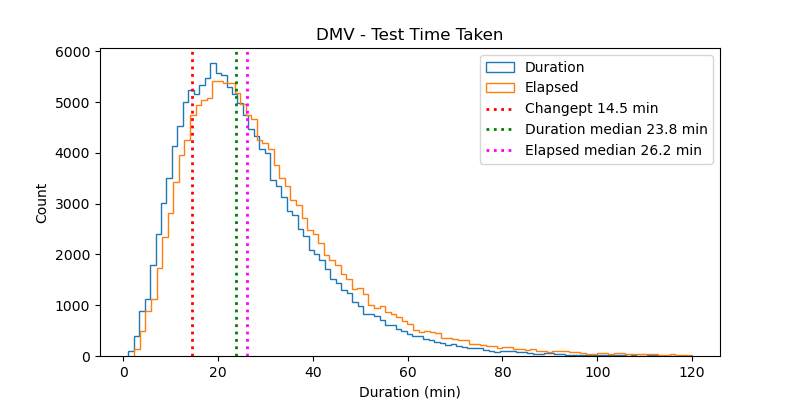

In [2]:
def draw_duration(x, changept, fw=8, fh=4):
    # Graph histogram to compare use of duration and elapsed time
    # duration ... time taken to finish test as reported in akts (min)
    # elapsed .... elapsed clock time from start to finish (min)
    fig, ax = plt.subplots(figsize=(fw, fh))

    h1 = ax.hist(x.duration, bins=100, histtype="step", label="Duration")
    h2 = ax.hist(x.elapsed, bins=100, histtype="step", label="Elapsed")

    duration_median = x.duration.median()
    elapsed_median = x.elapsed.median()
    
    l1 = ax.axvline(x=changept, color="red", linewidth=2, ls=":", label=f"Changept {changept} min")
    l2 = ax.axvline(x=duration_median, color="green", linewidth=2, ls=":", label=f"Duration median {duration_median:.1f} min")
    l3 = ax.axvline(x=elapsed_median, color="magenta", linewidth=2, ls=":", label=f"Elapsed median {elapsed_median:.1f} min")

    ax.set_title(f'DMV - Test Time Taken')
    ax.set_xlabel(f'Duration (min)')
    ax.set_ylabel(f'Count')
    ax.grid(False)
    ax.legend()
    plt.show
    return h1, ax

h1 = draw_duration(df, CHANGEPT)

<IPython.core.display.Javascript object>


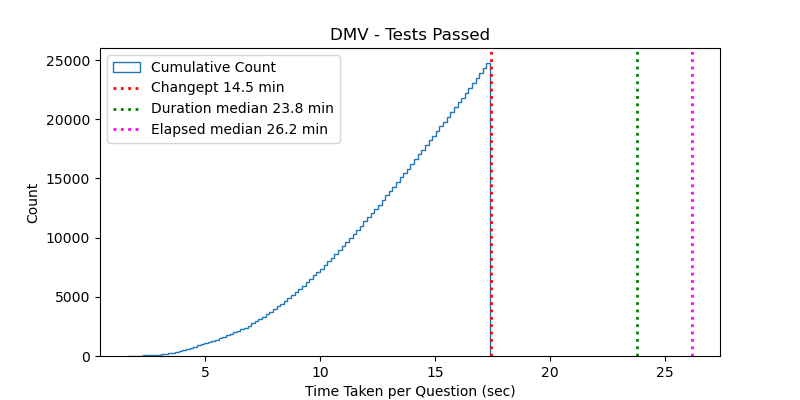

In [3]:
import mplcursors      # Allows interactive matplotlib graphs
def draw_duration_cum(df, changept, fw=8, fh=4):
    # Graph cumulative histogram to people passing in less than changept
    fig, ax = plt.subplots(figsize=(fw, fh))
    h1 = ax.hist(df[(df.duration<changept) & (df.passed==True)].duration*60/50, bins=100, histtype="step", label="Cumulative Count", cumulative=True)
    mplcursors.cursor(hover=True)

    duration_median = df.duration.median()
    elapsed_median = df.elapsed.median()
    
    l1 = ax.axvline(x=changept*60/50, color="red", linewidth=2, ls=":", label=f"Changept {changept} min")
    l2 = ax.axvline(x=duration_median, color="green", linewidth=2, ls=":", label=f"Duration median {duration_median:.1f} min")
    l3 = ax.axvline(x=elapsed_median, color="magenta", linewidth=2, ls=":", label=f"Elapsed median {elapsed_median:.1f} min")

    ax.set_title(f'DMV - Tests Passed')
    ax.set_xlabel(f'Time Taken per Question (sec)')
    ax.set_ylabel(f'Count')
    ax.grid(False)
    ax.legend()
    plt.show
    return h1, ax

hc1 = draw_duration_cum(df, CHANGEPT)

<IPython.core.display.Javascript object>


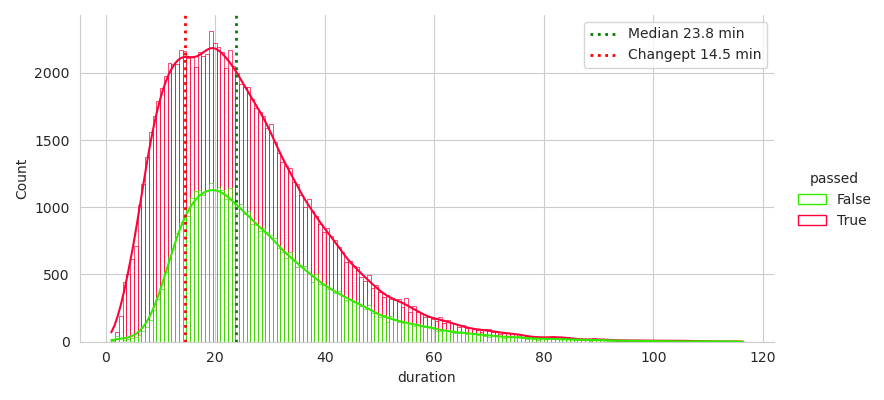

In [4]:
def duration_kde(df, field, vert, fw=8, fh=4):

    sns.set_style("whitegrid")
    g1 = sns.displot(data=df, x=field, hue="passed",
                     kde=True, 
                     palette='prism',
                     height=fh,
                     fill=False,
                     aspect=2)

    median = df[field].median()
    plt.axvline(x=median, color="green", linewidth=2, ls=":", label=f"Median {median:.1f} min")
    plt.axvline(x=vert, color="red", linewidth=2, ls=":", label=f"Changept {vert:.1f} min")

    plt.legend()
    return g1

g1 = duration_kde(df, "duration", 14.5)

<IPython.core.display.Javascript object>


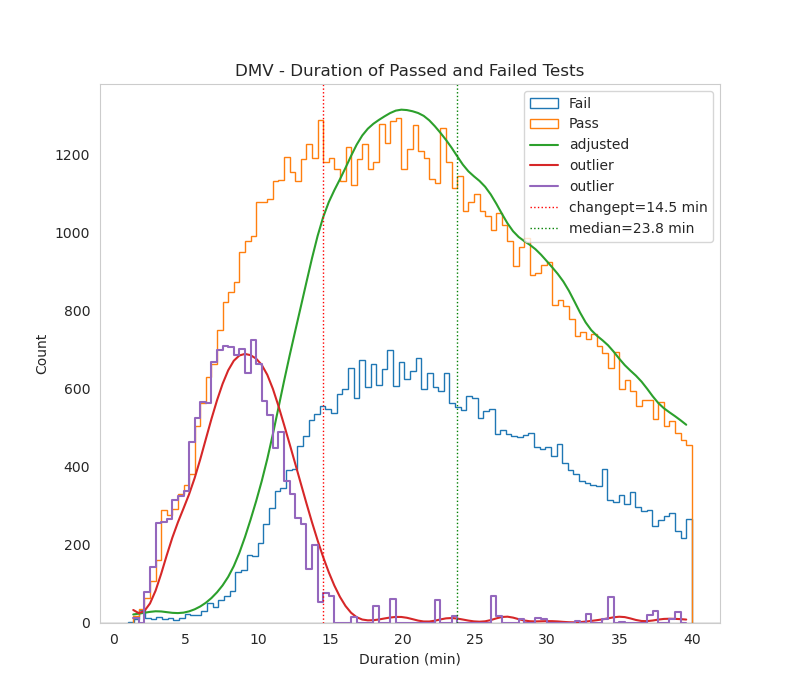

<IPython.core.display.Javascript object>


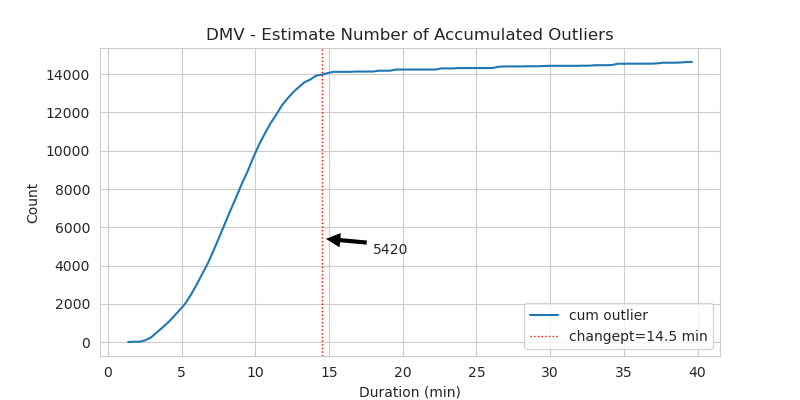

In [43]:
def draw_passfail_duration(x, changept, rate, fw=8, fh=4):
    # Graph compares tests that pass, fail to an estimate of outlier count
    # outliers are tests with scores higher than the long term average
    
    def smooth(x, y, order=3, num=100):
        # Smooth with a gaussian filter and then spline interpolation
        yfiltered = gaussian_filter(y, sigma=2)
        smoother = BSpline(x, yfiltered, order)
        u = np.linspace(x.min(), x.max(), num)

        return u, smoother(u)

    def draw_outlier_cum(p, changept, rate, median, fw=8, fh=4):
        # Draw the cumulative outliers
        # The number of outliers in each bin is count * binsize 
        binsize = p.duration.diff().mean()
#         p['cum_outlier'] = p.outlier.cumsum()*binsize
        p['cum_outlier'] = p.outlier.cumsum()

        fig, ax = plt.subplots(figsize=(fw, fh))
        ax.plot(p.duration, p.cum_outlier, label='cum outlier')
        ax.axvline(x=changept, color="red", linewidth=1, ls=":", label=f"{changept=} min")
        xy = (14.5, 5420)
        xytext = (18, 4600)
        ax.annotate('5420', xy=xy, xytext=xytext, arrowprops=dict(facecolor='black', shrink=0.05))
        ax.set_title(f'DMV - Estimate Number of Accumulated Outliers')
        ax.set_xlabel(f'Duration (min)')
        ax.set_ylabel(f'Count')
        ax.legend(loc='lower right')
        ax.grid(True)
        plt.show()
    
    # Find median of all the data
    median = x.duration.median()

    fig, ax = plt.subplots(figsize=(fw, fh))
    
    # Exclude tests that take a long time or have questionable time
    # Also minimizes the effect of long tail for short duration tests
    df = x[(x.duration > 0) & (x.duration <= 40) & (x.elapsed > 0) & (x.elapsed < 60)]
    
    # Draw histograms of the tests that pass and fail
    h1 = ax.hist(df[(df.Result!='P')].duration, bins=100, histtype="step", label="Fail")
    h2 = ax.hist(df[(df.Result=='P')].duration, bins=100, histtype="step", label="Pass")
    # Draw x=0 axis
    ax.axhline(y=0, color="gray", linewidth=1)

    # Use the counts calculated by plt.hist to find:
    # adjusted ... # tests expected to pass based on passing rate for duration > changept
    # outlier  ... # tests that occurred greater than the expected rate of passing
    # 
    # Exclude last duration, the outer edge of last bin. 
    # In following we use the calculated results made by plt.hist
    #    h1[0] ... counts of the people who failed in a duration bin
    #    h1[1] ... leading edge of the bin
    #    h2[0] ... counts of the people who passed in a duration bin
    #    h2[1] ... leading edge on the bin
    
    p = pd.DataFrame(h2[1][:-1], columns=['duration'])
    p['pass'] = h2[0]
    p['fail'] = h1[0]
    p['adjusted'] = p['fail']*(rate/(1. - rate))              # passing rate is .67
    p['outlier'] = p['pass'] - p['adjusted']
    # The number of outliers cannot be less than 0
    p['outlier'] = p['outlier'].apply(lambda x: x if x>0 else 0)

    # Smooth the jaggy histograms into a smooth curves
    u, v = smooth(p.duration, p.adjusted, order=2, num=100)
    h3 = ax.plot(u, v, label='adjusted')
#     h3 = ax.step(p.duration, p.adjusted, label='expected')

    u, v = smooth(p.duration, p.outlier, order=2, num=100)
    h4 = ax.plot(u, v, label='outlier')
    h5 = ax.step(p.duration, p['outlier'], label='outlier')

    # Display the changept and median
    ax.axvline(x=changept, color="red", linewidth=1, ls=":", label=f"{changept=} min")
    ax.axvline(x=median, color="green", linewidth=1, ls=":", label=f"{median=:.1f} min")

    ax.set_title(f'DMV - Duration of Passed and Failed Tests')
    ax.set_xlabel(f'Duration (min)')
    ax.set_ylabel(f'Count')
    ax.grid(False)
    ax.legend(loc='upper right')
    plt.show
    
    draw_outlier_cum(p, CHANGEPT, rate, median)
    return h1, h2, h3, h4, h5, p

h1, h2, h3, h4, h5, p = draw_passfail_duration(df, CHANGEPT, .67, fw=8, fh=7)

In [6]:
pd.qcut(df.duration,10)

0           (10.7, 14.317]
1           (20.6, 23.767]
2           (20.6, 23.767]
3          (23.767, 27.35]
4           (31.567, 37.2]
                ...       
148206    (14.317, 17.533]
148207      (20.6, 23.767]
148208      (10.7, 14.317]
148209      (31.567, 37.2]
148210      (17.533, 20.6]
Name: duration, Length: 148211, dtype: category
Categories (10, interval[float64, right]): [(1.016, 10.7] < (10.7, 14.317] < (14.317, 17.533] < (17.533, 20.6] ... (27.35, 31.567] < (31.567, 37.2] < (37.2, 46.2] < (46.2, 116.35]]

In [7]:
df.duration.describe()

count    148211.000000
mean         26.672522
std          14.897695
min           1.016667
25%          15.950000
50%          23.766667
75%          34.133333
max         116.350000
Name: duration, dtype: float64

In [8]:
np.quantile(df.duration, .99)



75.26333333333314

In [9]:
df["TestStartDateTime"].max()

Timestamp('2022-02-17 23:56:00.973000')

In [10]:
p1, p2= p[p.duration>CHANGEPT][['pass','fail']].sum()

In [11]:
p1,p2,p1/(p1+p2)

(61771.0, 31600.0, 0.6615651540628247)

In [12]:
p

,duration,pass,fail,adjusted,outlier,cum_outlier
0,1.366667,19.0,3.0,6.090909,12.909091,4.987212
1,1.753000,35.0,11.0,22.333333,12.666667,9.880768
2,2.139333,64.0,33.0,67.000000,0.000000,9.880768
3,2.525667,107.0,14.0,28.424242,78.575758,40.237202
4,2.912000,162.0,9.0,18.272727,143.727273,95.763838
...,...,...,...,...,...,...
95,38.068333,504.0,274.0,556.303030,0.000000,5640.185697
96,38.454667,518.0,283.0,574.575758,0.000000,5640.185697
97,38.841000,487.0,235.0,477.121212,9.878788,5644.002202
98,39.227333,470.0,218.0,442.606061,27.393939,5654.585394


In [20]:
p[['pass','fail','adjusted','outlier']].sum()

pass        86563.000000
fail        36955.000000
adjusted    75029.848485
outlier     14636.545455
dtype: float64

In [22]:
df[col].head()

,ExamineeId,TestStartDateTime,TotalScore,duration,elapsed,passed
0,3129715,2022-02-01 15:45:59.263,48,11.100000,12.428233,True
1,3129708,2022-02-01 18:59:40.910,45,23.733333,24.919000,True
2,3126868,2022-02-01 15:43:31.213,42,20.633333,22.084567,True
3,98266,2022-02-01 15:41:01.987,41,25.733333,36.776883,True
4,3129691,2022-02-01 15:41:00.907,44,31.883333,33.363100,True


In [23]:
df.passed.sum()

102626

In [33]:
c1 = df.duration<40

In [39]:
df[df.duration<40][['passed','failed','duration']].agg([sum,len])

,passed,failed,duration
sum,86967,37203,2686913.85
len,124170,124170,124170.00


In [42]:
col + ['failed']

['ExamineeId',
 'TestStartDateTime',
 'TotalScore',
 'duration',
 'elapsed',
 'passed',
 'failed']